In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import geopandas as gpd
import folium
from folium import Choropleth
import json
from branca.element import Figure

In [199]:
# load recent rent data 
rent_2024 = pd.read_csv('../../data/curated/cur_rent.csv')
rent_2024['postcode'] = rent_2024['postcode'].astype(str)

# load and prepare location data
postcode = gpd.read_file("../../data/raw/external/postcode/POSTCODE_POLYGON.shp")
postcode = postcode.to_crs(epsg=4326)
postcode = postcode.rename(columns={'POSTCODE': 'postcode'})
postcode['postcode'] = postcode['postcode'].astype(str)
postcode = postcode[['postcode','geometry']]

In [200]:
rent_2024 = rent_2024.groupby(['postcode']).agg(
    Mean=('Median', 'mean')  # Mean of weekly_rent
).reset_index()

In [201]:
merged = postcode.merge(rent_2024, on="postcode")

geojson = postcode.to_json()
geojson_dict = json.loads(geojson)

# Create a folium Map centered around the average location
map_center = [postcode.geometry.centroid.y.mean(), postcode.geometry.centroid.x.mean()]
fig = Figure(width=1000, height=800)
m = folium.Map(location=map_center, zoom_start=10.5)
fig.add_child(m)


# Add GeoJSON layer with color coding based on total rides
Choropleth(
    geo_data=merged.to_json(),
    name='choropleth',
    data=rent_2024,
    columns=['postcode', 'Mean'],
    key_on = 'feature.properties.postcode',
    fill_color='OrRd',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Rent in Vic'
).add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)
m.save('../../plots/current_geomap.html')

/var/folders/k7/_mb_sxqs3kq79v5w1cmsbshm0000gn/T/ipykernel_2638/2652259869.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [postcode.geometry.centroid.y.mean(), postcode.geometry.centroid.x.mean()]


The three graphs show the weekly rent versus the distance to the nearest public transport station (train station, LRT station and bus station), broken down by different number of bedrooms (1 to 4 rooms). The general trend shows that rents are higher when the distance is closer, especially for 3-and 4-room rents. As the distance increases, the rent tends to decrease, but it may fluctuate in some intermediate distance ranges. This reflects the impact of public transport convenience on the rental market, and the degree of impact varies among different housing types.

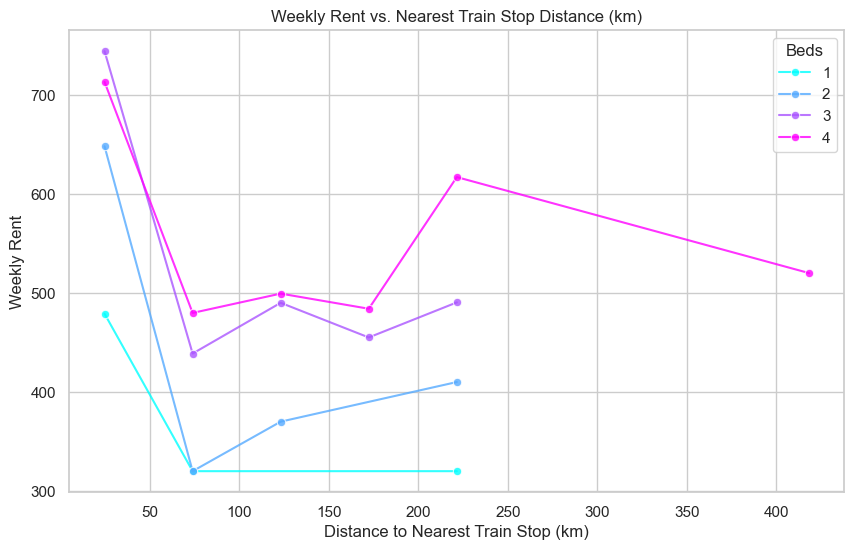

In [203]:
rent_loc = pd.read_csv("../../data/landing/2024_rent_loc.csv")
# Create bins for distance intervals
bins = np.linspace(rent_loc['nearest_train_stop_distance_km'].min(), rent_loc['nearest_train_stop_distance_km'].max(), 10)  # 10 equal intervals
rent_loc['distance_bin_train'] = pd.cut(rent_loc['nearest_train_stop_distance_km'], bins)

# Group by distance_bin and beds, then calculate the mean rent in each bin
df_grouped = rent_loc.groupby(['distance_bin_train', 'Bed'])['weekly_rent'].mean().reset_index()

# To avoid gaps in the plot, use the bin centers for x-axis values
bin_centers = (bins[:-1] + bins[1:]) / 2
df_grouped['bin_center'] = df_grouped['distance_bin_train'].apply(lambda x: x.mid)

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='bin_center', y='weekly_rent', hue='Bed', data=df_grouped, marker='o', alpha=0.8, palette='cool')

# Adding labels and title
plt.xlabel('Distance to Nearest Train Stop (km)')
plt.ylabel('Weekly Rent')
plt.title('Weekly Rent vs. Nearest Train Stop Distance (km)')

# Show plot with grid and legend
plt.legend(title='Beds')
plt.grid(True)
plt.savefig('../../plots/Weekly Rent vs. Nearest Train Stop Distance (km).png')

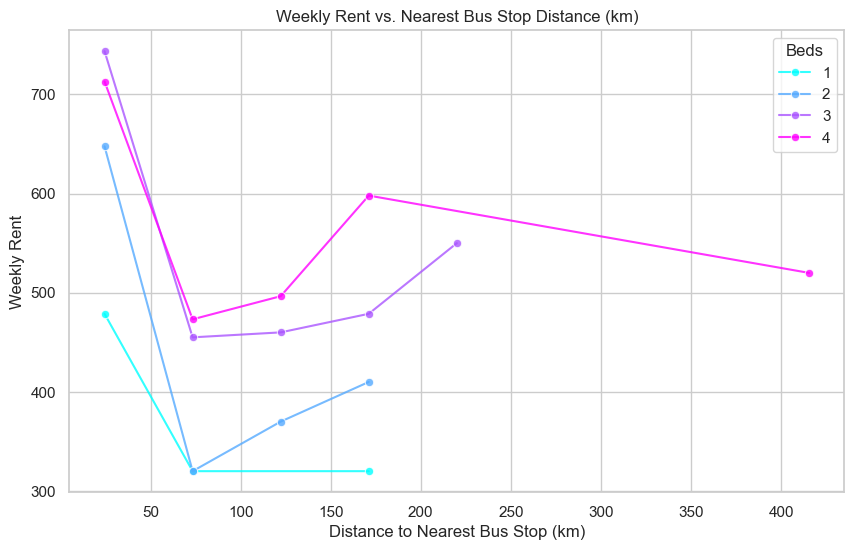

In [204]:
# Create bins for distance intervals
bins_bus = np.linspace(rent_loc['nearest_bus_stop_distance_km'].min(), rent_loc['nearest_bus_stop_distance_km'].max(), 10)  # 10 equal intervals
rent_loc['distance_bin_bus'] = pd.cut(rent_loc['nearest_bus_stop_distance_km'], bins_bus)

# Group by distance_bin and beds, then calculate the mean rent in each bin
df_grouped = rent_loc.groupby(['distance_bin_bus', 'Bed'])['weekly_rent'].mean().reset_index()

# To avoid gaps in the plot, use the bin centers for x-axis values
bin_centers = (bins_bus[:-1] + bins_bus[1:]) / 2
df_grouped['bin_center_2'] = df_grouped['distance_bin_bus'].apply(lambda x: x.mid)

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='bin_center_2', y='weekly_rent', hue='Bed', data=df_grouped, marker='o', alpha=0.8, palette='cool')

# Adding labels and title
plt.xlabel('Distance to Nearest Bus Stop (km)')
plt.ylabel('Weekly Rent')
plt.title('Weekly Rent vs. Nearest Bus Stop Distance (km)')

# Show plot with grid and legend
plt.legend(title='Beds')
plt.grid(True)
plt.savefig('../../plots/Weekly Rent vs. Nearest Bus Stop Distance (km).png')

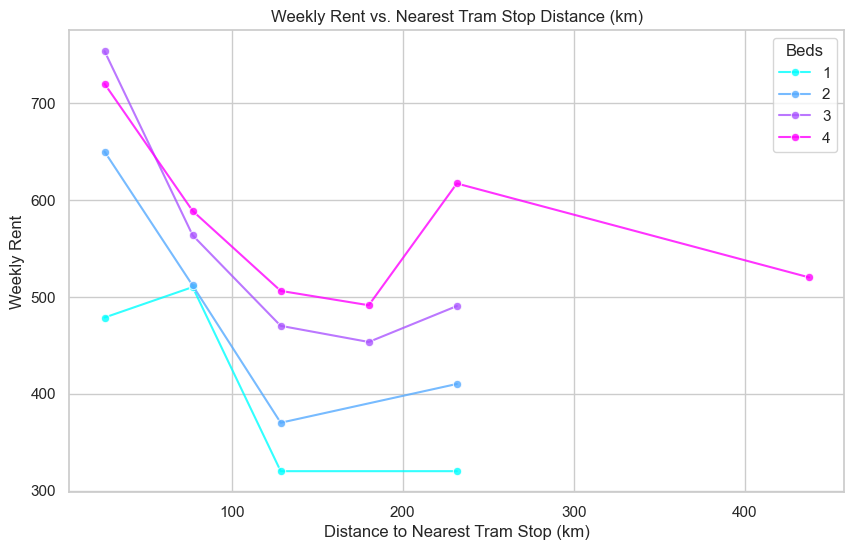

In [205]:
# Create bins for distance intervals
bins_tram = np.linspace(rent_loc['nearest_tram_stop_distance_km'].min(), rent_loc['nearest_tram_stop_distance_km'].max(), 10)  # 10 equal intervals
rent_loc['distance_bin_tram'] = pd.cut(rent_loc['nearest_tram_stop_distance_km'], bins_tram)

# Group by distance_bin and beds, then calculate the mean rent in each bin
df_grouped = rent_loc.groupby(['distance_bin_tram', 'Bed'])['weekly_rent'].mean().reset_index()

# To avoid gaps in the plot, use the bin centers for x-axis values
bin_centers = (bins_tram[:-1] + bins_tram[1:]) / 2
df_grouped['bin_center_3'] = df_grouped['distance_bin_tram'].apply(lambda x: x.mid)

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x='bin_center_3', y='weekly_rent', hue='Bed', data=df_grouped, marker='o', alpha=0.8, palette='cool')

# Adding labels and title
plt.xlabel('Distance to Nearest Tram Stop (km)')
plt.ylabel('Weekly Rent')
plt.title('Weekly Rent vs. Nearest Tram Stop Distance (km)')

# Show plot with grid and legend
plt.legend(title='Beds')
plt.grid(True)

plt.savefig('../../plots/Weekly Rent vs. Nearest Tram Stop Distance (km).png')

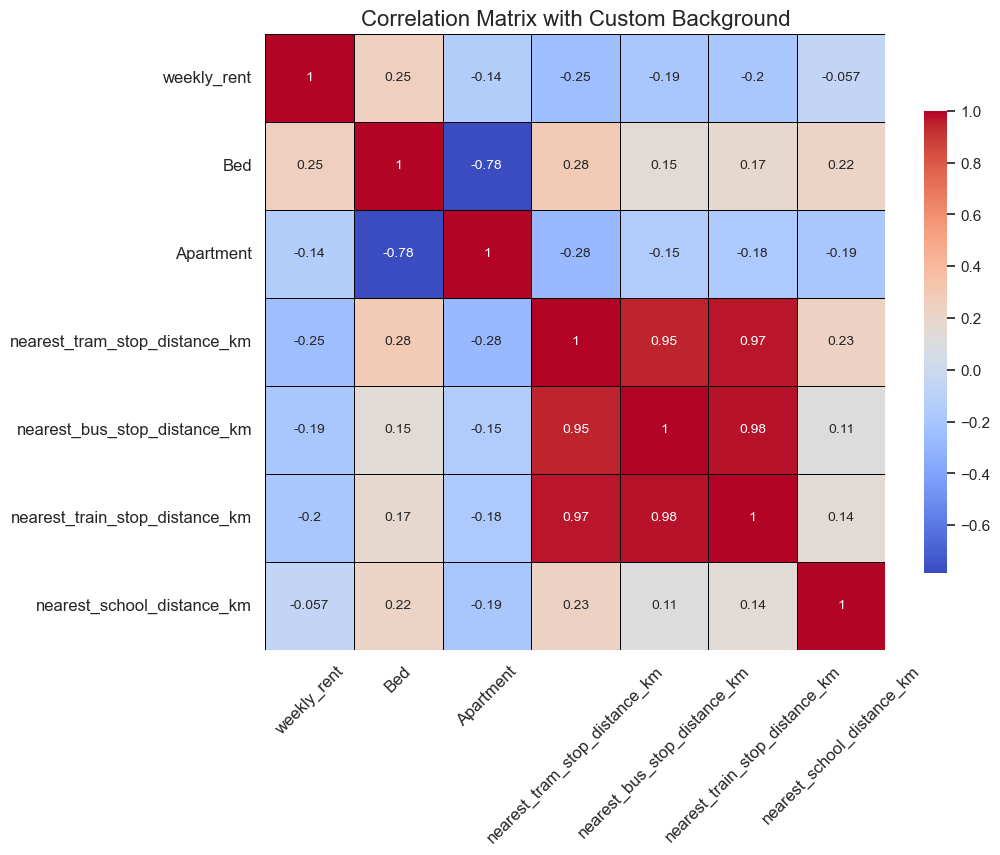

In [206]:
corr_matrix = rent_loc[['weekly_rent','Bed', 'Apartment', 'nearest_tram_stop_distance_km', 'nearest_bus_stop_distance_km', 'nearest_train_stop_distance_km', 'nearest_school_distance_km']].corr()
plt.figure(figsize=(10, 8))

sns.set(style="whitegrid")  
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', annot_kws={"size": 10}, 
                 cbar_kws={'shrink': 0.75}, 
                 facecolor="lightgrey")

plt.title("Correlation Matrix with Custom Background", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.savefig('../../plots/Correlation Matrix with Custom Background.png')

In [207]:
df = pd.read_csv('../../data/curated/train_data.csv')

This line chart shows the trend of median rents for apartments and houses from 2000 to 2023. The rent of a house is always higher than that of an apartment, and the gap widens over time. In 2000, the median rent was about $250; in 2020, it was nearly $550. The median rent for apartments has grown from about $200 to nearly $400. This trend reflects the increasing demand for homes in the rental market and the rising price of housing.

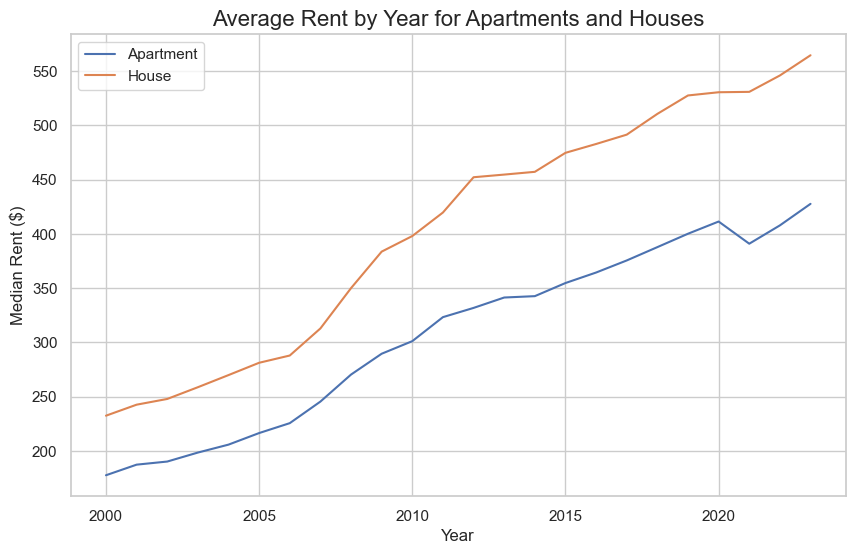

In [208]:
# Prepare the data and group it according to the conditions of Apartment=0 and 1
df_apartment = df[df['Apartment'] == 1].groupby('Year')['Median'].mean()
df_house = df[df['Apartment'] == 0].groupby('Year')['Median'].mean()

plt.figure(figsize=(10, 6))
plt.plot(df_apartment.index, df_apartment.values, label='Apartment')
plt.plot(df_house.index, df_house.values, label='House')

plt.title('Average Rent by Year for Apartments and Houses', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Rent ($)', fontsize=12)

plt.legend()

plt.grid(True)
plt.savefig('../../plots/Average Rent by Year for Apartments and Houses.png')

The bar chart shows the frequency distribution of the median rent, ranging from 0 to 1000. It can be seen in the figure that the number of listings with rent between 200 and 400 is the largest, with the frequency exceeding 6000, and the number of listings gradually decreases as the rent level increases. This indicates that the rental market is more active in the lower and middle price segments, while there are relatively few high-rent listings.

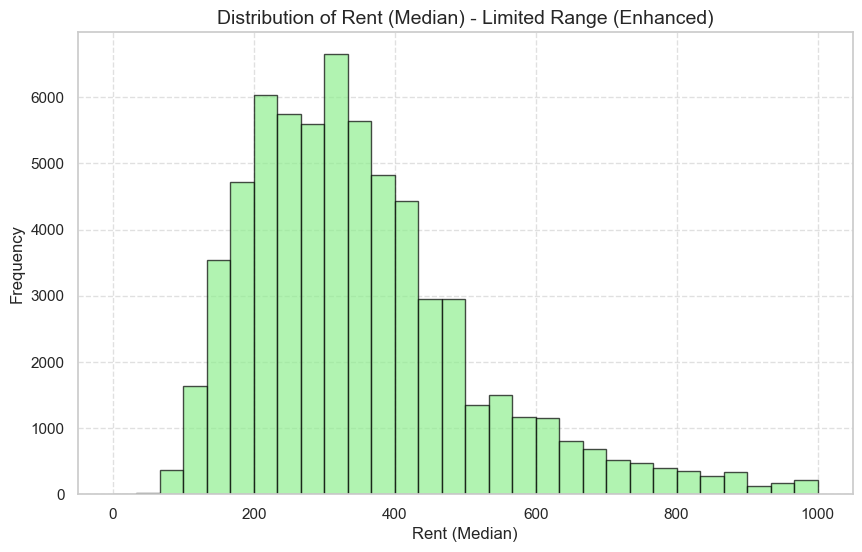

In [209]:
# Narrow the X-axis range, exclude extreme values, and select a reasonable interval (such as 0-1000) for histogram drawing
plt.figure(figsize=(10, 6))
plt.hist(df['Median'].dropna(), bins=30, range=(0, 1000), edgecolor='black', alpha=0.7, color='lightgreen')
plt.title('Distribution of Rent (Median) - Limited Range (Enhanced)', fontsize=14)
plt.xlabel('Rent (Median)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig('../../plots/Distribution of Rent (Median).png')

The correlation matrix shows how correlated the variables are with each other. There are strong positive relationships between median rent and year (0.51) and number of bedrooms (0.46), indicating that rents also tend to rise over time and with increasing number of bedrooms. The negative correlation with apartment type (-0.27) means that apartment rents are relatively low compared to houses. Moreover, the relationship between public facilities, such as the number of schools, bus stops and train stations, and rents is weaker, but some trends can still be observed.

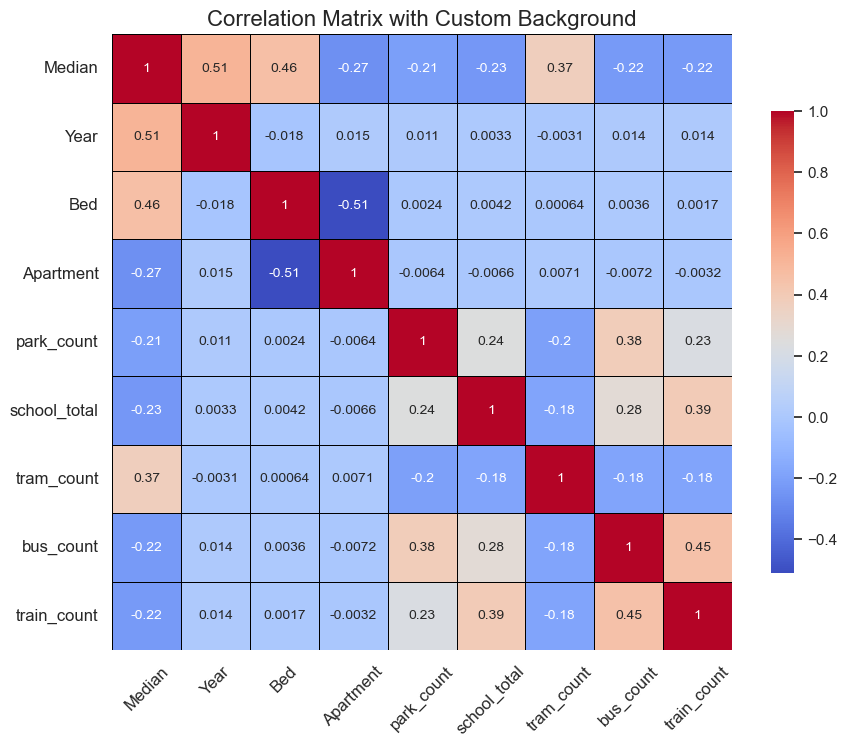

In [210]:
corr_matrix = df[['Median', 'Year', 'Bed', 'Apartment', 'park_count', 'school_total', 'tram_count', 'bus_count', 'train_count']].corr()
plt.figure(figsize=(10, 8))

sns.set(style="whitegrid")  
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black', annot_kws={"size": 10}, 
                 cbar_kws={'shrink': 0.75}, 
                 facecolor="lightgrey")

plt.title("Correlation Matrix with Custom Background", fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.savefig('../../plots/Correlation Matrix with Custom Background.png')

The bar chart shows the average rent for different number of bedrooms. The average rent is around $250 for a 1 bedroom, rising to around $350 for a 2 bedroom, $400 for a 3 bedroom, and close to $500 for a 4 bedroom. This indicates a gradual increase in rents as the number of bedrooms increases, reflecting a higher demand for larger living Spaces.

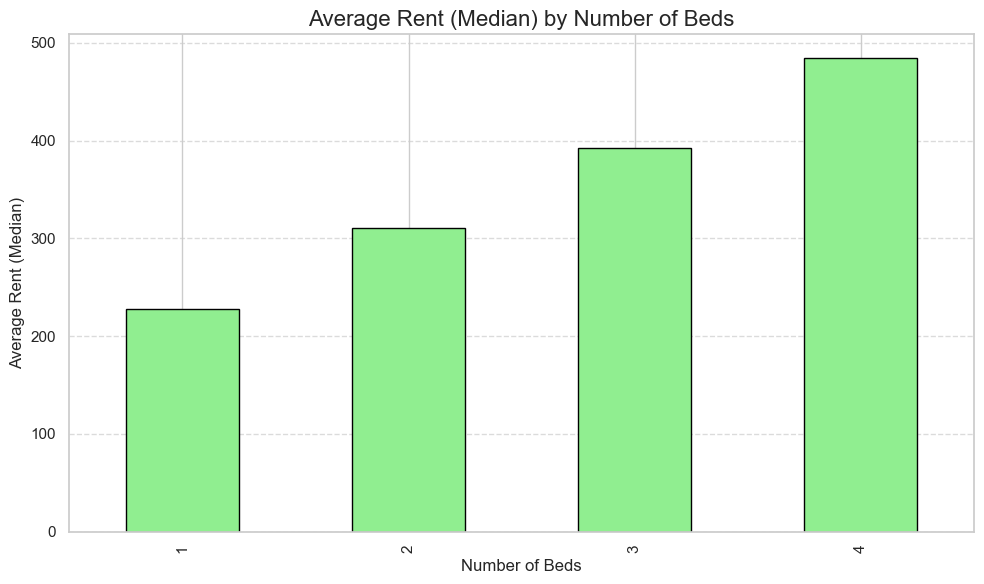

In [211]:
# Calculate the average median rent per bed and limit the number of beds to a maximum of 6
df_bed_median = df[df['Bed'] <= 6].groupby('Bed')['Median'].mean()

# Draw a bar chart
plt.figure(figsize=(10, 6))
df_bed_median.plot(kind='bar', color='lightgreen', edgecolor='black')

plt.title('Average Rent (Median) by Number of Beds', fontsize=16)
plt.xlabel('Number of Beds', fontsize=12)
plt.ylabel('Average Rent (Median)', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../../plots/Average Rent (Median) by Number of Beds.png')

This figure analyzes the effect of the total number of schools in the school district on apartment and house rents. As the number of schools increases from 0 to 20, there is a clear decrease in rents for both apartments and houses, especially for houses, where the decrease is even greater. This may indicate that rents are relatively more affordable in areas with more schools. Beyond 20 schools, the rent trend starts to pick up slightly, possibly influenced by other regional characteristics or high demand.

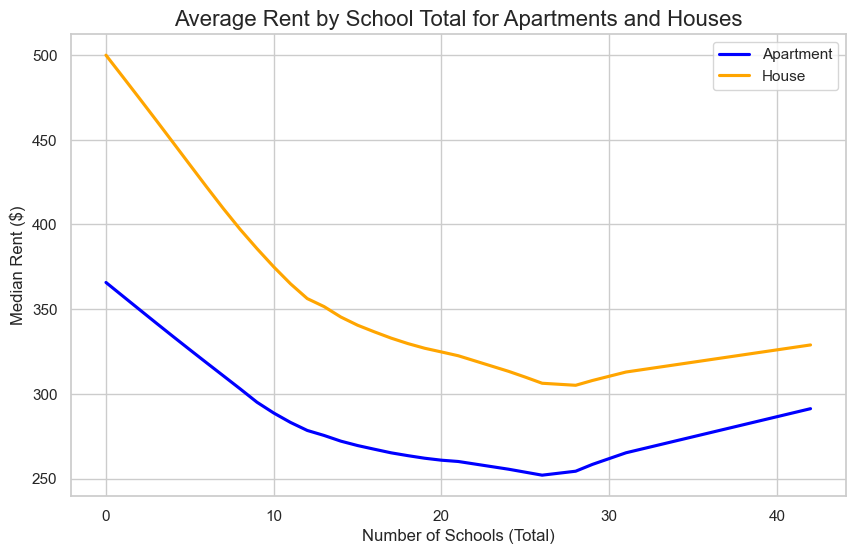

In [212]:
df_apartment = df[df['Apartment'] == 1].groupby('school_total')['Median'].mean()
df_house = df[df['Apartment'] == 0].groupby('school_total')['Median'].mean()

plt.figure(figsize=(10, 6))
sns.regplot(x=df_apartment.index, y=df_apartment.values, label='Apartment', lowess=True, scatter=False, color='blue')
sns.regplot(x=df_house.index, y=df_house.values, label='House', lowess=True, scatter=False, color='orange')

plt.title('Average Rent by School Total for Apartments and Houses', fontsize=16)
plt.xlabel('Number of Schools (Total)', fontsize=12)
plt.ylabel('Median Rent ($)', fontsize=12)

plt.legend()

plt.grid(True)
plt.savefig('../../plots/Average Rent by School Total for Apartments and Houses.png')